In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%pylab inline
import os.path
from os import path
pylab.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams.update({'font.size': 25,'legend.fontsize':25})#,'font.family': 'serif'})
pylab.rc('axes', linewidth=1)
params = {'text.usetex': True, 
          'text.latex.preamble': [r'\usepackage{cmbright}', r'\usepackage{amsmath}']}
pylab.rcParams.update(params)
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import AutoMinorLocator
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

Populating the interactive namespace from numpy and matplotlib


/home/weiszr/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [22]:
def motion_space_p(fr_l,fd_l,dis_l,ca):
    len_mc_l = len(fr_l)
    fr_dis_l = []
    fd_dis_l = []
    fr_ndis_l = []
    fd_ndis_l = []
    for i_mc in range(len_mc_l):
        if max(dis_l[:,i_mc]) >= ca:
            fr_dis_l.append(fr_l[i_mc])
            fd_dis_l.append(fd_l[i_mc])
        if max(dis_l[:,i_mc]) < ca:
            fr_ndis_l.append(fr_l[i_mc])
            fd_ndis_l.append(fd_l[i_mc])
    fr_dis_l = array(fr_dis_l)
    fd_dis_l = array(fd_dis_l)
    fr_ndis_l = array(fr_ndis_l)
    fd_ndis_l = array(fd_ndis_l)
    return fr_dis_l,fd_dis_l,fr_ndis_l,fd_ndis_l

def trans_fr(fr_l,fu_l,froude,d_fd):
    n_fdr_l = len(fr_l)
    fu = []
    for i in range(n_fdr_l):
        if fr_l[i] >= froude - d_fd and fr_l[i] <= froude + d_fd:
            fu.append(fu_l[i])
    fu = asarray(fu)
    
    if len(fu)== 0:
        tt = amax(fu_l)
    else:
        tt = amin(fu)     
    return(tt)

def make_outputfile(fig,tt='test',res=200):
    fname_eps = 'Fig_{t1}.eps'.format(t1=tt)
    fname_png = 'Fig_{t1}.png'.format(t1=tt)
    fname_pdf = 'Fig_{t1}.pdf'.format(t1=tt)
    fname_svg = 'Fig_{t1}.svg'.format(t1=tt)
    fig.savefig(fname_eps,bbox_inches='tight', transparent=True)
    fig.savefig(fname_png,dpi=res,bbox_inches='tight', transparent=True)
    fig.savefig(fname_pdf,dpi=res,bbox_inches='tight', transparent=True)
    fig.savefig(fname_svg,dpi=res,bbox_inches='tight', transparent=True)
    print("Files '{t1}', '{t3}', '{t2} and {t5}' created, where the latter two have dpi={t4}".format(t1=fname_eps,t2=fname_png,t3=fname_pdf,t5=fname_svg,t4=str(res)))
    

In [23]:
from src.helpers import det_runname,read_input_sldl,read_model_data,read_input,round_n
help(read_model_data)

Help on function read_model_data in module src.helpers:

read_model_data(path_l='./', environ='conv')
    Reading data saved in the given path. The program assumes that the input
    file for the boulder simulations are inside the directory



In [24]:
def exclude_unph_fr(fd_local1, fu_local1):
    fr_low = 0.5
    fr_high = 2.0
    dummy = []
    for i in range(len(fd_local1)):
        if fd_local1[i] != 0.0 and fu_local1[i] !=0.0:
            dummy.append(fu_local1[i]/(sqrt(9.81*fd_local1[i])))
        else:
            dummy.append(0.0)
    dummy = asarray(dummy)
    fd_local1[dummy<fr_low] = 'NaN'
    fu_local1[dummy<fr_low] = 'NaN'
    fd_local1[dummy>fr_high] = 'NaN'
    fu_local1[dummy>fr_high] = 'NaN'
    return fd_local1, fu_local1


In [25]:
def find_fr(fd_local, fu_local,fr_number_local):
    n_df = 0.01
    dummy = []
    nfd_local = []
    nfu_local = []
#    print(max(fd_local))
#    print(max(fu_local))
    for i in range(len(fd_local)):
        if fd_local[i] != 0.0 and fu_local[i] !=0.0:
            dummy_val = fu_local[i]/(sqrt(9.81*fd_local[i]))
            if dummy_val < fr_number_local+n_df and dummy_val > fr_number_local-n_df:
                nfd_local.append(fd_local[i])
                nfu_local.append(fu_local[i])
    #print(len(nfd_local),len(nfu_local))
    if len(nfd_local) != 0 and len(nfu_local) != 0:
        output1 = min(nfd_local)
        output2 = min(nfu_local)
    else:
        output1 = 'NaN'
        output2 = 'NaN'
    return output1,output2

def mask_zero(c_fu_dis_l,c_fd_dis_l,c_fu_ndis_l,c_fd_ndis_l):
    c_fu_dis_l[c_fu_dis_l == 0.0] = 'NaN'
    c_fd_dis_l[c_fd_dis_l == 0.0] = 'NaN'

    c_fu_ndis_l[c_fu_ndis_l == 0.0] = 'NaN'
    c_fd_ndis_l[c_fd_ndis_l == 0.0] = 'NaN'


    print(shape(c_fu_dis_l))
    nc_fu_dis_l = empty_like(c_fu_dis_l)
    nc_fu_dis1_l = empty_like(c_fu_dis_l)
    nc_fu_dis2_l = empty_like(c_fu_dis_l)

    nc_fu_ndis_l = empty_like(c_fu_ndis_l)
    nc_fd_dis_l = empty_like(c_fd_dis_l)
    nc_fd_ndis_l = empty_like(c_fd_ndis_l)
    for i in range(len(c_fd_dis_l[:,0])):
        nc_fd_dis_l[i,:],nc_fu_dis_l[i,:] = exclude_unph_fr(c_fd_dis_l[i,:],c_fu_dis_l[i,:])
        nc_fd_ndis_l[i,:],nc_fu_ndis_l[i,:] = exclude_unph_fr(c_fd_ndis_l[i,:],c_fu_ndis_l[i,:])
    return nc_fu_dis_l,nc_fd_dis_l,nc_fu_ndis_l,nc_fd_ndis_l

def froude_number(fd_local,fr_number_l):
    fu_local = []
    for i in range(len(fd_local)):
        fu_local.append(fr_number_l*sqrt(9.81*fd_local[i]))
    fu_local = asarray(fu_local)
    return fu_local


def find_trans(sl_change_l,dl_change_l,c_fd_dis_l,c_fu_dis_l,fr_value_l=1.0):
    index_array = zeros([len(sl_change_l),len(dl_change_l)],dtype=int)
    for j in range(len(sl_change_l)):
#        print(j*len(dl_change_l),(j)*len(dl_change_l)+len(dl_change_l)-1)
        index_array[j,:] = linspace(j*len(dl_change_l),(j)*len(dl_change_l)+len(dl_change_l)-1,len(dl_change_l),dtype=int)
    x1_d_l = empty_like(index_array,dtype=float)
    y1_d_l = empty_like(index_array,dtype=float)
#    print(shape(c_fd_dis_l))
    for i in range(len(sl_change_l)):
        for j in range(len(dl_change_l)):
            x1_d_l[i,j],y1_d_l[i,j] = find_fr(c_fd_dis_l[index_array[i,j],:],c_fu_dis_l[index_array[i,j],:],fr_value_l)

    return x1_d_l,y1_d_l



In [26]:
def read_data_parameter(inputfile,p_name):
    with open(inputfile) as f:
        lines = f.readlines()
        dummy =[]
        for line in lines:
            if line.split()[0] == p_name: 
                dummy.append(float(line.split()[-1])) 
    dummy = float(dummy[-1])
    return dummy 

def read_model_data_sum(path_l):
#from boulder.in file    
    boulder_in_name = '{t1}boulder{t2}.in'.format(t1=path_l,t2=path_l[-4:-1])
    dens_l = read_data_parameter(boulder_in_name,'min_density:')
    aaa_l = read_data_parameter(boulder_in_name,'a-axis:')
    bbb_l = read_data_parameter(boulder_in_name,'b-axis:')
    ccc_l = read_data_parameter(boulder_in_name,'c-axis:')
    sl_change_l = loadtxt(path_l+'slope.dat')
    dl_change_l = loadtxt(path_l+'delta.dat')
    c_fu_dis_l = loadtxt(path_l+'u_dis.dat')
    c_fd_dis_l = loadtxt(path_l+'d_dis.dat')
    c_fu_ndis_l = loadtxt(path_l+'d_dis.dat')
    c_fd_ndis_l = loadtxt(path_l+'d_dis.dat')
#    print(path_l+'slope.dat')
#    sl_change_l = array(sl_change_l)
#    dl_change_l = array(dl_change_l)
#    print(nanmax(c_fu_dis_l))
    return aaa_l,bbb_l,ccc_l,dens_l,sl_change_l,dl_change_l,c_fu_dis_l,c_fd_dis_l,c_fu_ndis_l,c_fd_ndis_l

In [27]:
dumm1,dumm1,dumm1,dumm1,sl_change1,dl_change1,c_fu_dis1,dumm1,dumm1,dumm1 = read_model_data_sum('./data/ddd/data_density000/')
print(shape(c_fu_dis1))

nx1 = len(sl_change1)
nx2 = len(dl_change1)
dd,nx3 = shape(c_fu_dis1)
nt = 25
a = zeros(nt)
b = zeros(nt)
c = zeros(nt)
dens = zeros(nt)
sl_change = zeros([nt,nx1])
dl_change = zeros([nt,nx2])

x1 = zeros([nt,nx1,nx2])
y1 = zeros([nt,nx1,nx2])


c_fu_dis =  zeros([nt,nx1*nx2,nx3])
c_fd_dis =  zeros([nt,nx1*nx2,nx3])
c_fu_ndis = zeros([nt,nx1*nx2,nx3])
c_fd_ndis = zeros([nt,nx1*nx2,nx3])

nc_fu_dis =  zeros([nt,nx1*nx2,nx3])
nc_fd_dis =  zeros([nt,nx1*nx2,nx3])
nc_fu_ndis = zeros([nt,nx1*nx2,nx3])
nc_fd_ndis = zeros([nt,nx1*nx2,nx3])

print(shape(x1))

(90, 5000)
(25, 5, 18)


In [28]:
for nt_i in range(nt):
    folder = './data/ddd/data_density{t1:03d}/'.format(t1=nt_i)
    a[nt_i],b[nt_i],c[nt_i],dens[nt_i],sl_change[nt_i,:],dl_change[nt_i,:],c_fu_dis[nt_i,:,:],\
    c_fd_dis[nt_i,:,:],c_fu_ndis[nt_i,:,:],c_fd_ndis[nt_i,:,:] = read_model_data_sum(folder)

In [29]:
print(a,b,c,dens,dl_change[nt_i,:])

[1.19 1.42 2.75 1.7  1.05 1.94 1.45 2.16 1.65 2.   2.55 2.06 1.35 1.01
 1.85 1.58 1.66 2.08 1.54 1.79 1.37 1.83 2.54 2.7  2.69] [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2.] [1.34 2.54 1.73 2.28 2.89 2.17 1.83 1.38 2.68 2.   1.88 1.26 1.05 1.14
 2.14 1.69 1.36 2.07 1.34 1.32 2.71 1.97 2.56 2.81 2.41] [1919.9 2157.5 1624.2 1678.6 2175.4 2299.1 1943.1 1734.4 2081.9 2042.5
 1808.  1971.  2357.3 1696.3 2227.4 2327.  2125.3 2271.8 2374.3 1831.
 2125.2 2269.3 1927.3 2181.9 1739.9] [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]


In [30]:
for nt_i in range(nt):
    nc_fu_dis[nt_i,:,:],nc_fd_dis[nt_i,:,:],nc_fu_ndis[nt_i,:,:],nc_fd_ndis[nt_i,:,:] = mask_zero(c_fu_dis[nt_i,:,:],c_fd_dis[nt_i,:,:],c_fu_ndis[nt_i,:,:],c_fd_ndis[nt_i,:,:])
print(nanmax(nc_fu_dis[1:,:]))


(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
(90, 5000)
25.5


In [31]:
for nt_i in range(nt):
    x1[nt_i,:,:],y1[nt_i,:,:] = find_trans(sl_change[nt_i,:],dl_change[nt_i,:],nc_fd_dis[nt_i,:,:],nc_fu_dis[nt_i,:,:])


In [32]:
#def calc_average(arr):
    

In [33]:
nt=25
c_xp10=[]
c_xnul=[]
c_xn10=[]

for nt_i in range(nt):
    mass = dens[nt_i] * (c[nt_i] * b[nt_i] * a[nt_i])
    aspect_r = a[nt_i]/c[nt_i]
    c_xn10.append(aspect_r**(0) * (dens[nt_i] * a[nt_i] * c[nt_i] * x1[nt_i,0,:])/mass)
    c_xnul.append(aspect_r**(0) * (dens[nt_i] * a[nt_i] * c[nt_i] * x1[nt_i,2,:])/mass)
    c_xp10.append(aspect_r**(0) * (dens[nt_i] * a[nt_i] * c[nt_i] * x1[nt_i,4,:])/mass)

c_xp10 = array(c_xp10) 
c_xnul = array(c_xnul) 
c_xn10 = array(c_xn10) 

average_xm10 = []
average_xnul = []
average_xp10 = []
for nx2_i in range(nx2):
    average_xm10.append(nanmean(c_xn10[:,nx2_i]))
    average_xnul.append(nanmean(c_xnul[:,nx2_i]))
    #average_p10.append(nanmean(c_xp10[:,nx2_i]))
    average_xp10.append(nanmean(c_xp10[:,nx2_i]))
average_xm10 = array(average_xm10)
average_xnul = array(average_xnul)
average_xp10 = array(average_xp10)


average_xm10[-1]=average_xm10[-2]+(average_xm10[-2]-average_xm10[-3])
average_xnul[-1]=average_xnul[-2]+(average_xnul[-2]-average_xnul[-3])
average_xp10[-1]=average_xp10[-2]+(average_xp10[-2]-average_xp10[-3])

print(average_xp10)

[2.149924   2.090222   2.31291    2.324896   2.405754   2.586542
 2.688642   2.953664   3.0554     3.309762   3.729368   4.081406
 4.690842   5.20255208 6.02233913 7.195405   8.37509091 9.55477682]


In [34]:
###This is the cell I need to change
nt=25
c_yp10=[]
c_ynul=[]
c_yn10=[]
g=9.81
for nt_i in range(nt):
    mass = dens[nt_i] * (c[nt_i] * b[nt_i] * a[nt_i])
    aspect_r = a[nt_i]/c[nt_i]
    c_yn10.append(aspect_r**(0) * mass*y1[nt_i,0,:]**2 /(g*a[nt_i]**2.0 * c[nt_i]**2.0 * dens[nt_i]))
    c_ynul.append(aspect_r**(0) * mass*y1[nt_i,2,:]**2/(g*a[nt_i]**2.0 * c[nt_i]**2.0 * dens[nt_i]))
    c_yp10.append(aspect_r**(0) * mass*y1[nt_i,4,:]**2/(g*a[nt_i]**2.0 * c[nt_i]**2.0 * dens[nt_i]))
    
    
# KG / M^3

# KG * M^3/KG * S^2/M^2 * 1/M^2 * 1/M^2

#        KG M^3 S^2
#           KG M^4
        
#         KG S^2
#         KG M

# mass * FD/
# g *rho )a

# KG M^2/S^2 M^3/KG *1/M^2 * 1/M^2 S^2/M
# KG M^2 M^3 S^2
# KG S^2 M^2 M^2 M

c_yp10 = array(c_yp10) 
c_ynul = array(c_ynul) 
c_yn10 = array(c_yn10) 

average_ym10 = []
average_ynul = []
average_yp10 = []
for nx2_i in range(nx2):
    average_ym10.append(nanmean(c_yn10[:,nx2_i]))
    average_ynul.append(nanmean(c_ynul[:,nx2_i]))
    #average_yp10.append(nanmean(c_yp10[:,nx2_i]))
    average_yp10.append(nanmean(c_yp10[:,nx2_i]))
average_ym10 = array(average_ym10)
average_ynul = array(average_ynul)
average_yp10 = array(average_yp10)


average_ym10[-1]=average_ym10[-2]+(average_ym10[-2]-average_ym10[-3])
average_ynul[-1]=average_ynul[-2]+(average_ynul[-2]-average_ynul[-3])
average_yp10[-1]=average_yp10[-2]+(average_yp10[-2]-average_yp10[-3])
print(average_yp10)

[3.14790053 3.11090068 3.35317638 3.37977161 3.53422625 3.73127331
 4.04904687 4.37382158 4.54325184 4.90682366 5.52680362 6.09572372
 7.07174502 7.21055542 8.14604295 9.20899691 9.46568171 9.72236651]


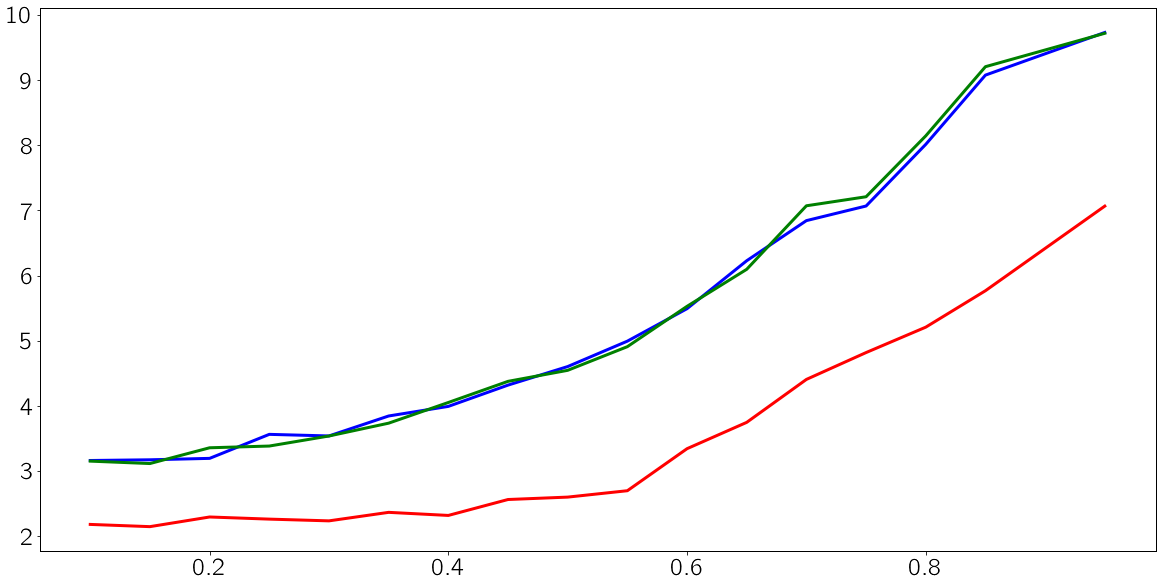

In [35]:
plot(dl_change[0,:],average_ym10,'r-',lw=3)
plot(dl_change[0,:],average_ynul,'b-',lw=3)
plot(dl_change[0,:],average_yp10,'g-',lw=3)

flow depth
(25, 5, 18)
18


(0.0, 10.0)

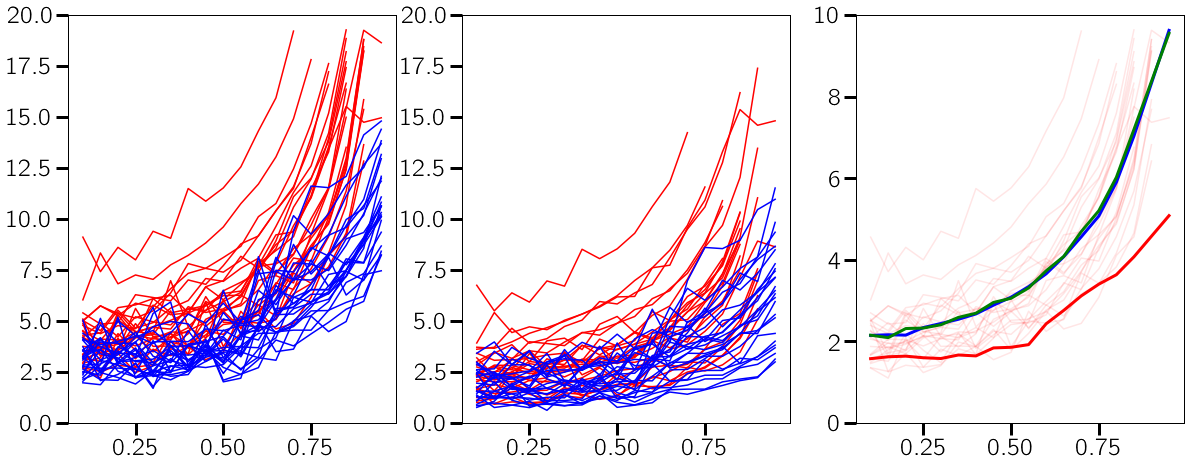

In [36]:
fig, (ax1,ax2,ax3) = subplots(nrows=1,ncols=3,figsize=(20,7.5)) 
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')

flow_depth = linspace(0.0,20.0,100)
al=0.1
li=3
#print(sl_change0,sl_change1,sl_change2)
print("flow depth")
ax1.tick_params(which='both', width=3)
ax1.tick_params(which='major', length=12)
ax2.tick_params(which='both', width=3)
ax2.tick_params(which='major', length=12)
ax3.tick_params(which='both', width=3)
ax3.tick_params(which='major', length=12)

index1=-1
index2=0
#print(mass0,mass1,mass2)
for nt_i in range(nt):
    ax1.plot(dl_change[nt_i,:],(x1[nt_i,index1,:]),'r-')
    
for nt_i in range(nt):
    ax1.plot(dl_change[nt_i,:],(x1[nt_i,index2,:]),'b-')




ax1.set_ylim(0,20)

#ax1.legend()
#ax1.set_ylim(0,10)
for nt_i in range(nt):
    aspect_r = a[nt_i]/c[nt_i]
    ax2.plot(dl_change[nt_i,:],aspect_r**(-1)*(x1[nt_i,index1,:])/c[nt_i],'r-')

for nt_i in range(nt):
    aspect_r = a[nt_i]/c[nt_i]
    ax2.plot(dl_change[nt_i,:],aspect_r**(-1)*(x1[nt_i,index2,:])/c[nt_i],'b-')





ax2.set_ylim(0,20)

for nt_i in range(nt):
    mass = dens[nt_i] * (c[nt_i] * b[nt_i] * a[nt_i])
    aspect_r = a[nt_i]/c[nt_i]
    ax3.plot(dl_change[nt_i,:],aspect_r**(0) * (dens[nt_i] * a[nt_i] * c[nt_i] * x1[nt_i,index1,:])/mass,'r-',alpha=0.1)


print(shape(x1))  
print(nx2)

for nt_i in range(nt):
    mass = dens[nt_i] * (c[nt_i] * b[nt_i] * a[nt_i])
    aspect_r = a[nt_i]/c[nt_i]
    
 #   ax3.plot(dl_change[nt_i,:],aspect_r**(0) * (dens[nt_i] * a[nt_i] * c[nt_i] * x1[nt_i,index2,:])/mass,'b-')
#    ax3.plot(dl_change[nt_i,:],x1[nt_i,:],'b-',alpha=0.1)
ax3.plot(dl_change[0,:],average_xm10,'r-',lw=3)
ax3.plot(dl_change[0,:],average_xnul,'b-',lw=3)
ax3.plot(dl_change[0,:],average_xp10,'g-',lw=3)

ax3.set_ylim(0,10)





#ax3.legend()
#ax3.set_ylim(0,10)



In [37]:
def make_lines(data_x,data_y):
    z = polyfit(data_x, data_y, 4)
    f = poly1d(z)

    # calculate new x's and y's
    x_new = np.linspace(data_x[0], data_x[-1], 50)
    y_new = f(x_new)
    return x_new,y_new

Text(0.11, 9.5, '(b)')

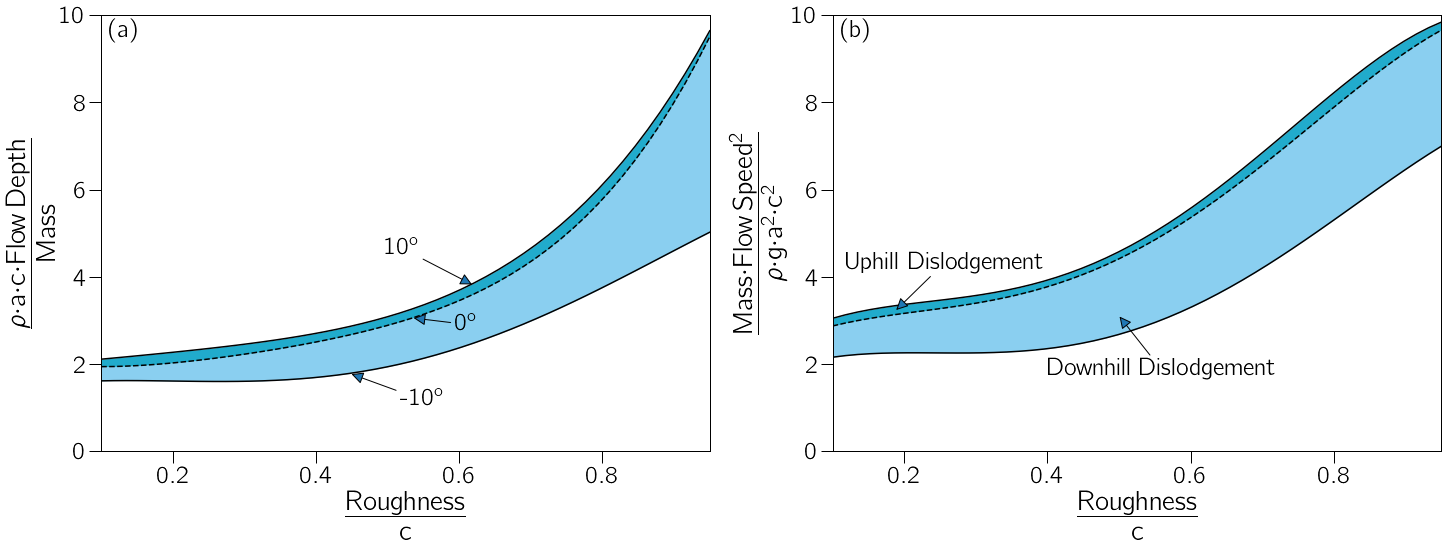

In [38]:
# x1,y1 = make_lines(dl_change,x2_d[0,:])
# x2,y2 = make_lines(dl_change,x2_d[-1,:])
# x3,y3 = make_lines(dl_change,x2_d[2,:])
color_ar = [(0.54, 0.81, 0.94),(0.13, 0.67, 0.8)]

fig, (ax1,ax2) = subplots(nrows=1,ncols=2,figsize=(20,7.5),constrained_layout=True)#,gridspec_kw = {'wspace':0.3, 'hspace':0}) 
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')

flow_depth = linspace(0.0,20.0,100)
al=0.1
li=3

ax1.tick_params(which='both', width=1)
ax1.tick_params(which='major', length=12)
ax2.tick_params(which='both', width=1)
ax2.tick_params(which='major', length=12)
# for i in range(len(sl_change)):
#     ax1.scatter(dl_change,x2_d[i,:],label=str(sl_change[i]))
#ax3.plot(dl_change[0,:],average_m10,'r-',lw=3)
#ax3.plot(dl_change[0,:],average_nul,'b-',lw=3)
#ax3.plot(dl_change[0,:],average_p10,'g-',lw=3)

nx_1,ny_1 = make_lines(dl_change[0,:],average_xm10)
nx_2,ny_2 = make_lines(dl_change[0,:],average_xnul)
nx_3,ny_3 = make_lines(dl_change[0,:],average_xp10)

ax1.fill_between(nx_1,ny_1,ny_2-0.2, color=color_ar[0],lw=0)
ax1.fill_between(nx_1,ny_2-0.2,ny_3, color=color_ar[1],lw=0)
ax1.plot(nx_1,ny_1,'k-')
ax1.plot(nx_2,ny_2-0.2,'k--')
ax1.plot(nx_3,ny_3,'k-')
ax1.set_ylim(0,10)
ax1.annotate( r'-10$^\mathrm{o}$', xy=(nx_1[20], ny_1[20]), xytext=(nx_1[20]+0.1,ny_1[20]-0.75), ha='center', \
            arrowprops={'arrowstyle':'-|>'})
ax1.annotate( r'10$^\mathrm{o}$', xy=(nx_2[30], ny_2[30]), xytext=(nx_2[30]-0.1,ny_2[30]+0.7), ha='center', \
            arrowprops={'arrowstyle':'-|>'})
ax1.annotate( r'0$^\mathrm{o}$', xy=(nx_3[25], ny_3[25]-0.2), xytext=(nx_3[25]+0.075,ny_3[25]-0.5), ha='center', \
            arrowprops={'arrowstyle':'-|>'})
ax1.set_xlim(0.1,0.95)
ax1.set_xlabel(r'$\frac{\mathrm{Roughness}}{\mathrm{c}}$',size=40,fontweight='bold')
#ax1.set_xlabel('Roughness [m]',fontweight='bold')
ax1.set_ylabel(r"$\frac{\rho \cdot\mathrm{a \cdot c \cdot Flow\,Depth}}{\mathrm{Mass}}$",size=40)
#ax1.text(0.12,0.2,'Fr = 1.0 for (a) \& (b)')
ax1.text(0.11,9.5,'(a)',size=25)

# for i in range(len(sl_change)):
#     ax2.scatter(dl_change,y2_d[i,:],label=str(sl_change[i]))
nx_1,ny_1 = make_lines(dl_change[0,:],average_ym10)
nx_2,ny_2 = make_lines(dl_change[0,:],average_ynul)
nx_3,ny_3 = make_lines(dl_change[0,:],average_yp10)
ax2.fill_between(nx_1,ny_1,ny_2-0.2, color=color_ar[0],lw=0)
ax2.fill_between(nx_1,ny_2-0.2,ny_3, color=color_ar[1],lw=0)
ax2.plot(nx_3,ny_3,'k-')
ax2.plot(nx_2,ny_2-0.2,'k--')
ax2.plot(nx_1,ny_1,'k-')
#\definecolor{bondiblue}{rgb}{0.37, 0.62, 0.63}
#\definecolor{camouflagegreen}{rgb}{0.47, 0.53, 0.42}
ax2.annotate('Downhill Dislodgement', xy=(nx_1[23], ny_1[23]+0.45), xytext=(nx_1[23]+0.06,ny_1[23]-.95), ha='center', \
            arrowprops={'arrowstyle':'-|>'})
ax2.annotate('Uphill Dislodgement', xy=(nx_2[5], ny_2[5]-0.125), xytext=(nx_2[5]+0.07,ny_2[5]+0.85), ha='center', \
            arrowprops={'arrowstyle':'-|>'})
ax2.set_xlim(0.1,0.95)
#ax1.legend()
ax2.set_ylim(0,10)
ax2.set_xlabel(r'$\frac{\mathrm{Roughness}}{\mathrm{c}}$',size=40,fontweight='bold')
ax2.set_ylabel(r"$\frac{\mathrm{Mass \cdot Flow\,Speed^2}}{\rho \cdot \mathrm{g \cdot a^2 \cdot c^2}}$",size=40)
#mass*y1[nt_i,0,:]**2 /(g*a[nt_i]**2.0 * c[nt_i]**2.0 * dens[nt_i]))
#ax2.set_ylabel(r'Flow Speed [m s $^{\mathbf{-1}}$]',fontweight='bold')
ax2.text(0.11,9.5,'(b)',size=25)

In [20]:
#make_outputfile(fig,tt='compv2',res=400)